# Example how to store the events from algorithms in the dataclass per recording file

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from ngmt.modules import GSDB, ICDA
from ngmt.utils.importers import import_hasomed_imu
from ngmt.utils.ngmt_data_classes import EventData

from ngmt.config import cfg_colors

First we load the data and put the in the desired dataclasses.

```python

In [2]:
# set path
path_example = r'C:\Users\User\Desktop\kiel\NGMT\examples\data\exDataHasomed.csv'

# load data via the hasomed importer and returns a RecordingData object
data = import_hasomed_imu(path_example)

# select only data channels of type accceleration (ACCEL)
type_oi = 'ACCEL'
acc = data.pick_channel_types(type_oi)

Data has 27 channels and 3332 samples
Time series has 3332 samples


Select the appropriate part of the data for the GSD algorithm.

In [3]:
# select only data channels of type accceleration (ACCEL)
type_oi = 'ACCEL'
acc = data.pick_channel_types(type_oi)

# only use the last three columns of the data (lower back)
acc_data_lower_back = []
acc_data_lower_back = acc.data[:,-3:]

# Use Gait_Sequence_Detection to detect gait sequence 
gait_sequences = GSDB.Gait_Sequence_Detection(imu_acceleration=acc_data_lower_back, sampling_frequency=data.sampling_frequency,plot_results=False)


Gait sequence(s) detected.


Move the detected events into the Event class.

In [4]:
# get all but the last key of the dictionary
event_nms = list(gait_sequences[0].keys())[:-1]
event_onsets = list(gait_sequences[0].values())[:-1]
event_durations = [1] * len(event_onsets)
data.events = EventData(name=event_nms, onset=event_onsets, duration=event_durations)

Detect inital contacts

In [5]:
# Now, use Initial_Contact_Detection to detect initial contacts within detected gait sequences.
initial_contacts = ICDA.Initial_Contact_Detection(imu_acceleration=acc_data_lower_back, gait_sequences=gait_sequences, sampling_frequency=data.sampling_frequency, plot_results=False)


In [6]:
initial_contacts

[{'Start': 8.4,
  'End': 26.825,
  'fs': 100.0,
  'IC': [8.775,
   9.4,
   10.075000000000001,
   10.625,
   11.275,
   11.850000000000001,
   12.45,
   13.05,
   13.65,
   14.25,
   14.850000000000001,
   15.4,
   15.95,
   16.575000000000003,
   17.175,
   17.775,
   18.35,
   19.0,
   19.6,
   20.175,
   20.700000000000003,
   21.325000000000003,
   21.925,
   22.55,
   23.125,
   23.775,
   24.35,
   24.950000000000003,
   25.575000000000003,
   26.225],
  'SamplingFrequency': 100.0}]

In [7]:
event_durations

[1, 1]

In [8]:
# create labels ic1, ic2, ic3, ic4, .. for the initial contacts dict
event_nms = ['ic' + str(i) for i in range(len(initial_contacts[0]["IC"]))]
# get the time stamps of the initial contacts
event_onsets = initial_contacts[0]["IC"][:-1]
event_durations = [1] * len(event_onsets)
data.events.add_events(name=event_nms, onset=event_onsets, duration=event_durations);

Plot the data and GSD events and ICD events in different colors.

[8.4, 26.825]


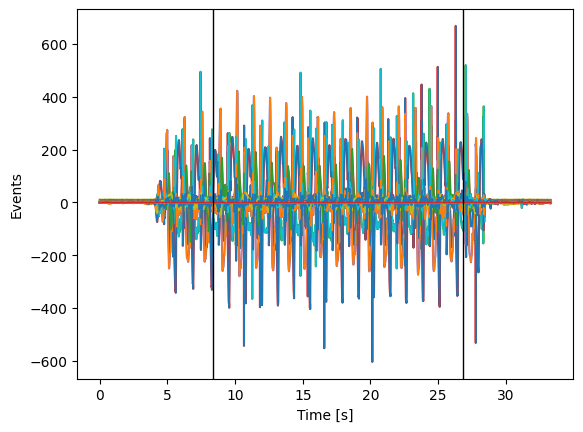

In [12]:
# plot the data
fig, ax = plt.subplots(1, 1,)
ax.plot(data.times, data.data);

# plot the events (Start and end) in red, all events containing ic in grey
data.plot_events(event_types_oi=['Start', 'End'])
